In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
import sklearn
# import statsmodels.formula.api as sm
import statsmodels.api as sm

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, RANSACRegressor, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR, OneClassSVM
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.evaluate import bias_variance_decomp


In [3]:
print(sklearn.__version__)

1.0.1


In [4]:
%run functions.ipynb

In [5]:
plt.style.use('seaborn')

# ПРОЕКТ ЗА СЪЗДАВАНЕ НА МОДЕЛИ ЗА ПРЕДСКАЗВАНЕ НА ЦЕНИ НА НЕДВИЖИМИ ИМОТИ - ЕДНОФАМИЛНИ ЖИЛИЩА

Оценката на цените на жилищата е важно финансово решение за всички участници на пазара на жилища - предприемачи, брокери, оценители, финансови институции и потенциални купувачи. Независимо от ролята на всеки един в процесите, които протичат, всеки един субект се интересува от потенциалната печалба, от пазарната стойност на обекта, който придобива или печалбата, която може да реализира.<br> 
По дефиниция,  в ЕВРОПЕЙСКИТЕ СТАНДАРТИ ЗА ОЦЕНЯВАНЕ (EСО) - 2020 г., определението за „Пазарна стойност” е: „Оценената сума, срещу която даден актив или пасив може да смени собственика си към датата на оценката чрез сделка между независими един от друг, желаещ купувач и желаещ продавач, след подходящ маркетинг, при което всяка от страните е действала информирано, благоразумно и без принуда”.<br>
В този проект ще разгледаме възможни алгоритми за машинно обучение, с цел да бъде разработена система за прогнозиране на цени на жилищата, а не на тяхната пазарната стойност.<br>
Изследването се състои от четири етапа, а именно:
* четене на предварително събрани данни, запълване на липсващи стойности, обработка на независимите променливи, анализ и трансформация във формат, подходящ да бъдат приложени в тренирането на модели за машинно обучение.
* разработка на модели за машинно обучение
* валидиране и тестване на моделите
* сравнение, анализ и избор на най-успешния модел

ХИПОТЕЗА<br>
Опитът в оценяването на недвижими имоти, показва, че стойността, на която се извършват сделките, често е повлияна от субективни фактори, както и явления на пазара, които могат да останат скрити. В резултат на това,  се приема за нормално становището на независим оценител за пазарната стойност на обект, да се различава от стойността на реализацията му.<br> Стартираме проекта, при допускането, че данните с които ще работим са "замърсени" от явления и решения, които не могат да бъдат обективно измерени и описани, както и че целта е предвиждане на евентуална цена на реализация, а не извеждане на пазарна стойност на обектите. <br> 
Негласно, в пактиката на оценяването, се допуска, че в изведената пазарна стойност за един и същи имот, на двама независимо работещи един от друг оценители или от стойността на сделката, може да има отклонение в размер на от 5-7%. 
На тази база, изследванията в настоящият проект ще бъдат използвани, за да се разгледат два въпроса в предвиждането на цени на недвижими имоти.<br> 
1. Предвиждане на цена на пакет/портфейл от недвижими имоти.<br>
Може ли да бъде обучен модел, който да предвиди цената на портфейл от имоти. Приема се, че това е така, ако средният процент на остатъците /residuals/ за целият сет е по-малко или равно на 5% - 7% от тестовият сет.

За целите на настоящия проект се използват данни от https://www.kaggle.com/c/house-prices-advanced-regression-techniques

### 1. Прочитане и запознаване с данните

In [6]:
train = pd.read_csv('train.csv')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.shape

(1460, 81)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 2. Почистване на данните и попълване на липсващи стойности

Премахваме излишната колона с индекси и поради високите стойности на продажните цени, да ги преобразуваме в стойност в хил USD.

In [9]:
train = train.drop('Id', axis=1)

In [10]:
train.shape

(1460, 80)

In [11]:
train.SalePrice = train.SalePrice.divide(other=1000)

От описанието на сета се вижда, че в част от променливите има липсващи стойности. Престъпваме към анализът им и запълването им.

In [12]:
missing_values = train.isnull().sum()
missing_values[missing_values>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

* Има 19 категории в данните, вкоито има липсващи стойности.<br>
* Нечислови променливи - Alley, MasVnrType, BsmtQual, BsmtCond, BsmtExposure,   BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu,  GarageType,   GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature - След обследване на променливите се вижда, че липсващите стойности в нечисловите променливи са всъщност клас, който показва отсъствието на комфорт факторът и затова същата се заменя с  "Not available".<br>
* Числови променливи  LotFrontage, MasVnrArea, GarageYrBlt се запълват със средната стойност за категорията. 

In [13]:
# Запълвам всички нечислови липсващи стойности с "not available"
for col in train.select_dtypes(exclude = ['int64', 'float64']): 
    train[col].fillna('Not available', inplace= True)

In [14]:
# Числовите променливи LotFrontage, MasVnrArea, GarageYrBlt, запълваме със средната за променливата стойност.
train['LotFrontage'].fillna(train['LotFrontage'].mean(), inplace=True)
train['MasVnrArea'].fillna(train['MasVnrArea'].mean(), inplace=True)
train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean(), inplace=True)

In [15]:
# Правим проверка дали стойностите са запълнени.
train.isna().sum().sum()

0

In [16]:
# Присвояваме към променливи числовите и нечисловите колони
categorical_columns = train.select_dtypes(include=['object'])
numerical_columns = train.select_dtypes(exclude=['object'])

In [17]:
len(categorical_columns.columns), len(numerical_columns.columns), len(train.columns)

(43, 37, 80)

### Анализ на числовите променливи

In [102]:
numerical_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.000,50.000000,70.00,190.0
LotFrontage,1460.0,70.049958,22.024023,21.0,60.000,70.049958,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.500,9478.500000,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.000,6.000000,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.000,5.000000,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.000,1973.000000,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.000,1994.000000,2004.00,2010.0
MasVnrArea,1460.0,103.685262,180.569112,0.0,0.000,0.000000,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.000,383.500000,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.000,0.000000,0.00,1474.0


In [19]:
# numerical_features_correlation = train.corr()
# numerical_features_correlation.sort_values(["SalePrice"], ascending = False, inplace=True)
# numerical_features_correlation.SalePrice.head(30)

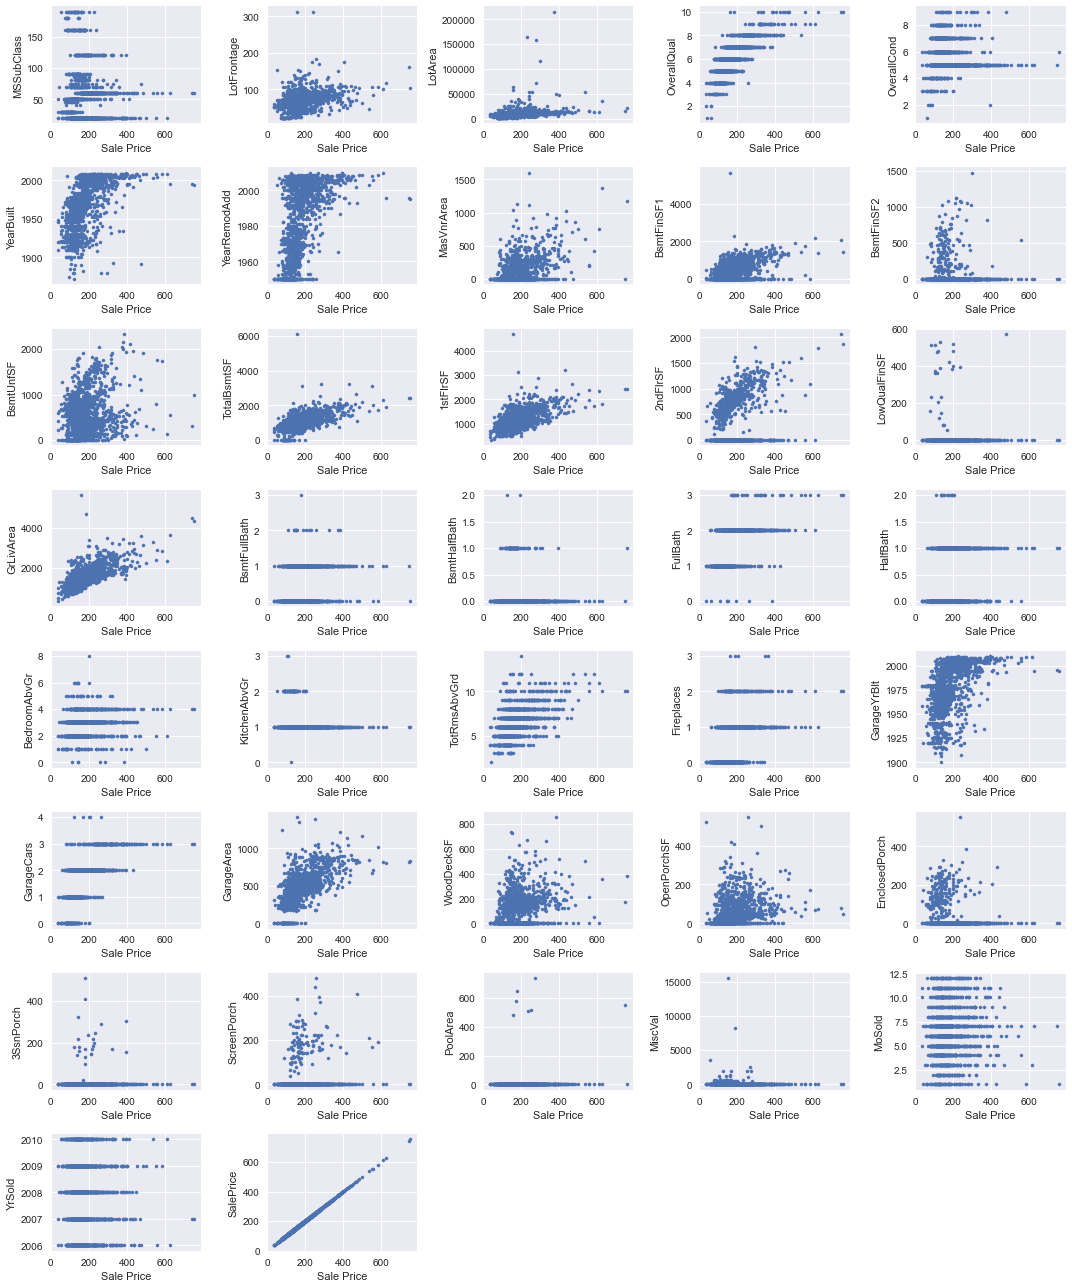

In [20]:
plt.figure(figsize=(15, 18))

i = 1
for col in numerical_columns:
    plt.subplot(8,5,i)
    plt.scatter(train.SalePrice, train[col], s=10)
    plt.xlabel('Sale Price')
    plt.ylabel(col)
    i +=1
    
plt.tight_layout()
plt.show()

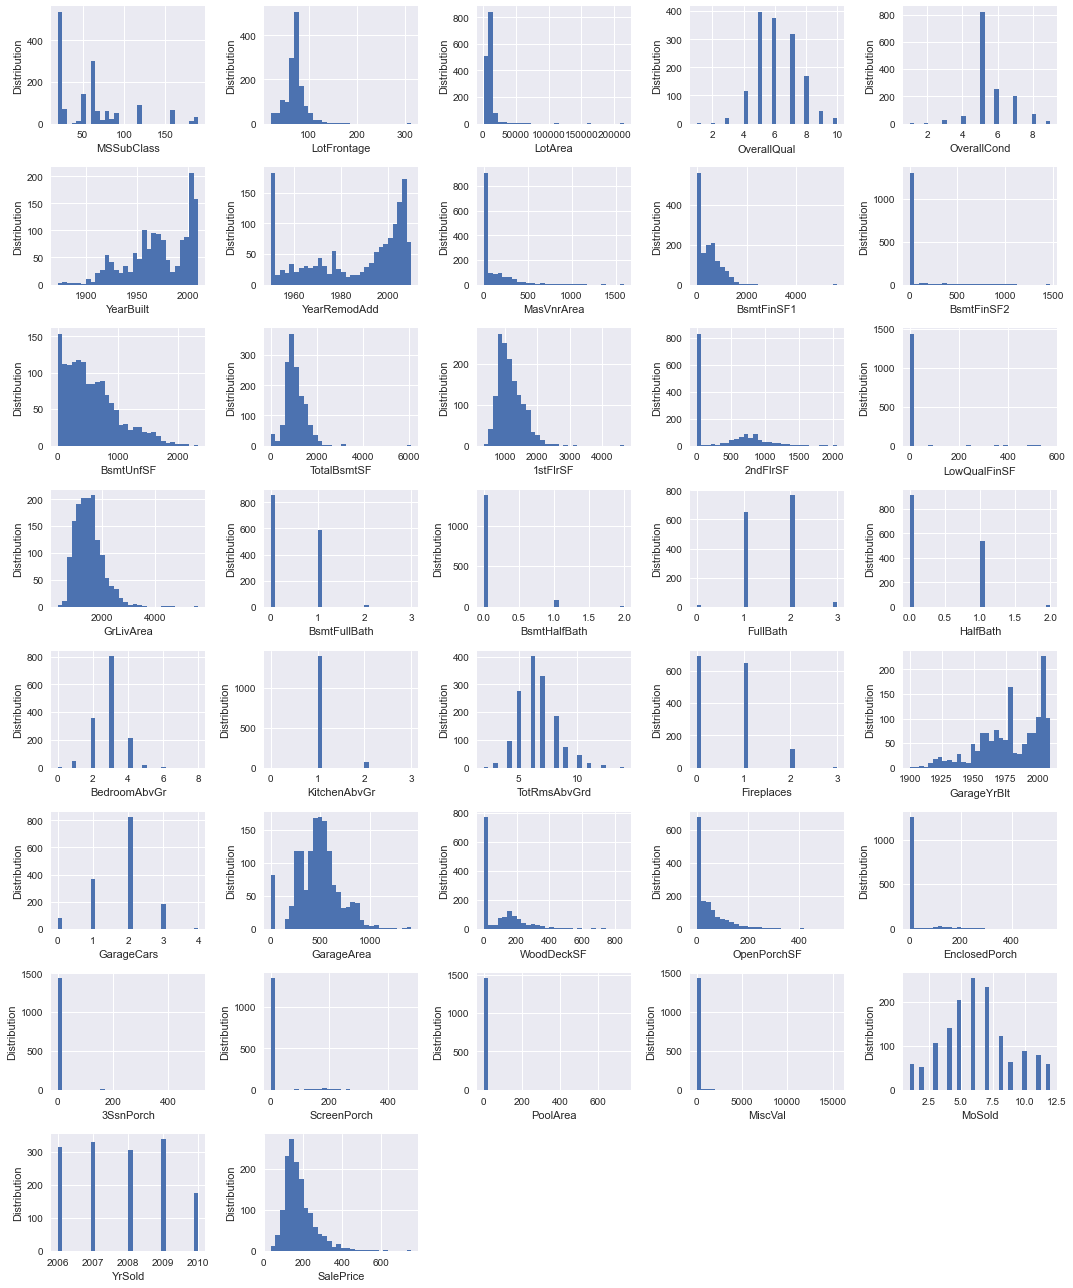

In [21]:
plt.figure(figsize=(15, 18))

i = 1
for col in numerical_columns:
    plt.subplot(8,5,i)
    plt.hist(train[col], bins=30)
    plt.xlabel(col)
    plt.ylabel('Distribution')
    i +=1
    
plt.tight_layout()
plt.show()

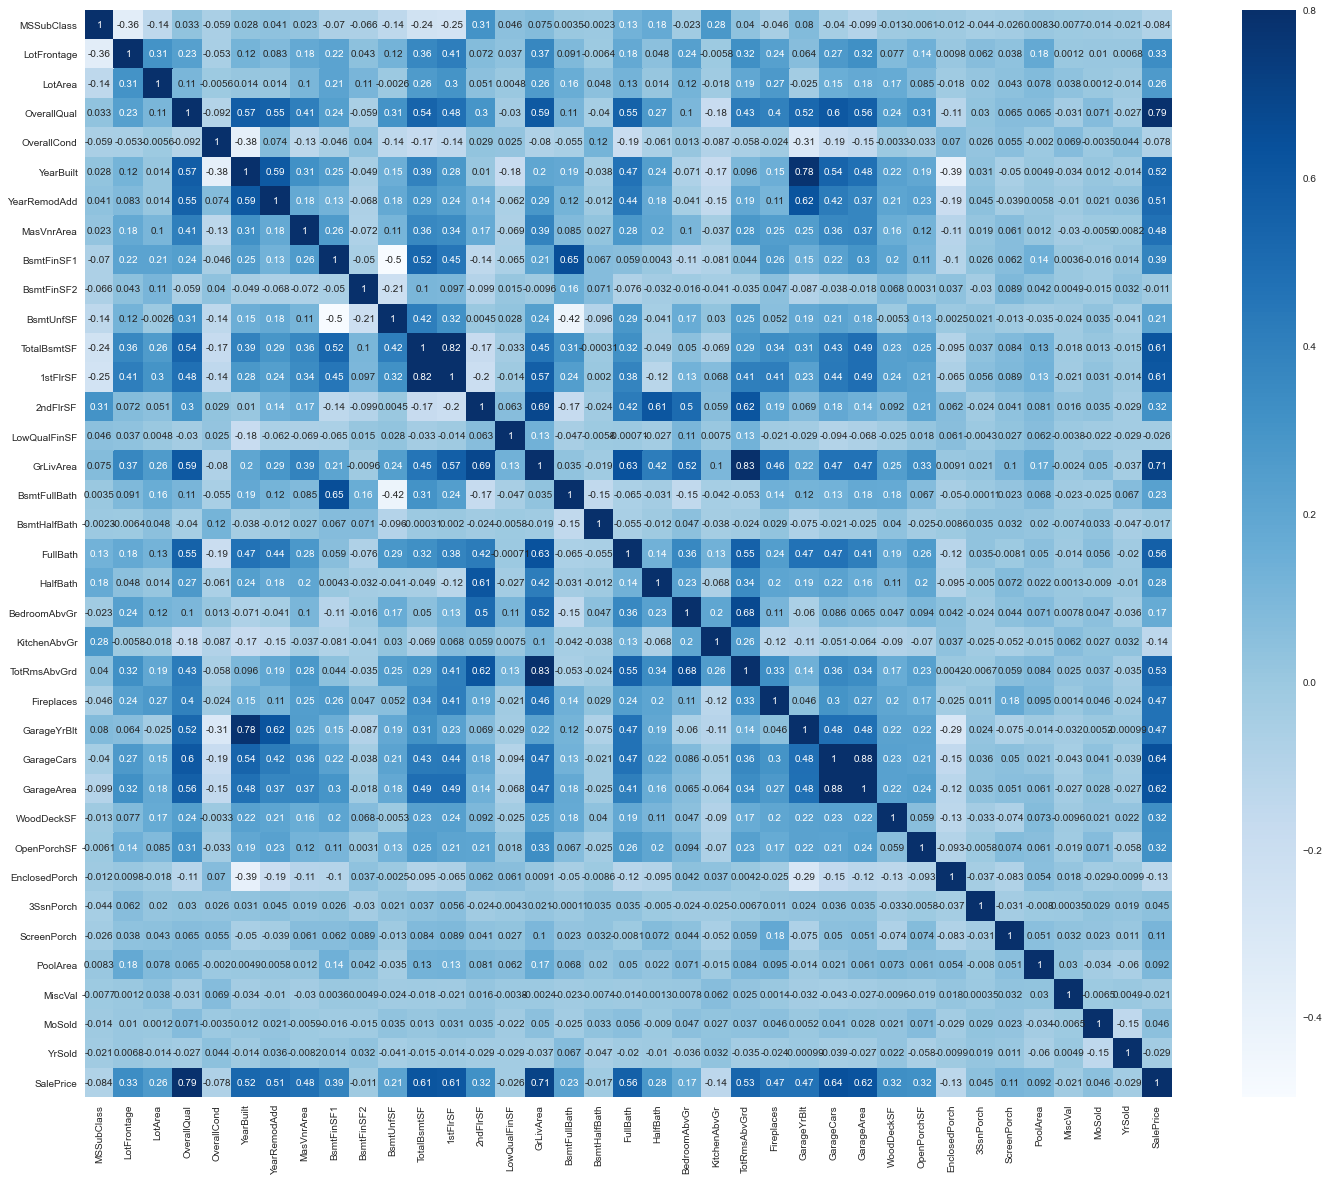

In [22]:
corr_mat = train.corr()
k = len(train.columns)
cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values)
f, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(corr_mat, vmax=.8, square=True, annot = True, cmap = 'Blues')
plt.show()

#### Фючър селекшън на цифровите променливи

Премахваме променливите, които са с корелация м/у -0,05 и 0,05 и които на практика почи не оказват влияние върху стойността.

In [23]:
low_price_corr_columns = corr_mat['SalePrice'][abs(corr_mat['SalePrice'].values) < 0.05].index.values
low_price_corr_columns

array(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch',
       'MiscVal', 'MoSold', 'YrSold'], dtype=object)

Площта на гаража и броят коли, за които е предназначен са напрактика препокриващи се променливи, силно зависими една от друга. Премахваме площтта, която е смалко по-ниска корелация.

In [25]:
train = train.drop('GarageArea', axis=1)
train = train.drop('GarageYrBlt', axis=1)

Махаме променливата за площ на втори етаж. Има колони с цялата площ и с площта на първия етаж, а площщта на втория етаж е разлика от двете. В същата променлива има много нулеви стойности, тъй като голяма част от сградите са едноетажни.

In [26]:
train = train.drop(['2ndFlrSF'], axis=1)
train = train.drop('1stFlrSF', axis=1)

Премахваме променливата за незавършен сутерен, тъй като имаме площ на целия сутерен и стойност на завършената част от него.

In [27]:
train = train.drop('BsmtUnfSF', axis=1)
train = train.drop('BsmtFinSF1', axis=1)

In [28]:
train = train.drop('TotRmsAbvGrd', axis=1)

Променливата PoolQC има 1453 липсващи стойности от общо 1460 записа, поради което приемаме, че тя не носи стойност към цената.

In [29]:
train = train.drop('PoolQC', axis=1)

#### Анализ на категорийните променливи

In [30]:
# Превръщам цифровите променливи, които по смисълът си трябва да са категорийни, също преобразувам в такива.
train.MSSubClass = train.MSSubClass.astype('object')

In [31]:
# презаписвам променливата след направената корекция
categorical_columns = train.select_dtypes(include=['object'])

In [32]:
categorical_description_df = categorical_columns.describe().T
categorical_description_df

,count,unique,top,freq
MSSubClass,1460,15,20,536
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,1460,3,Not available,1369
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225


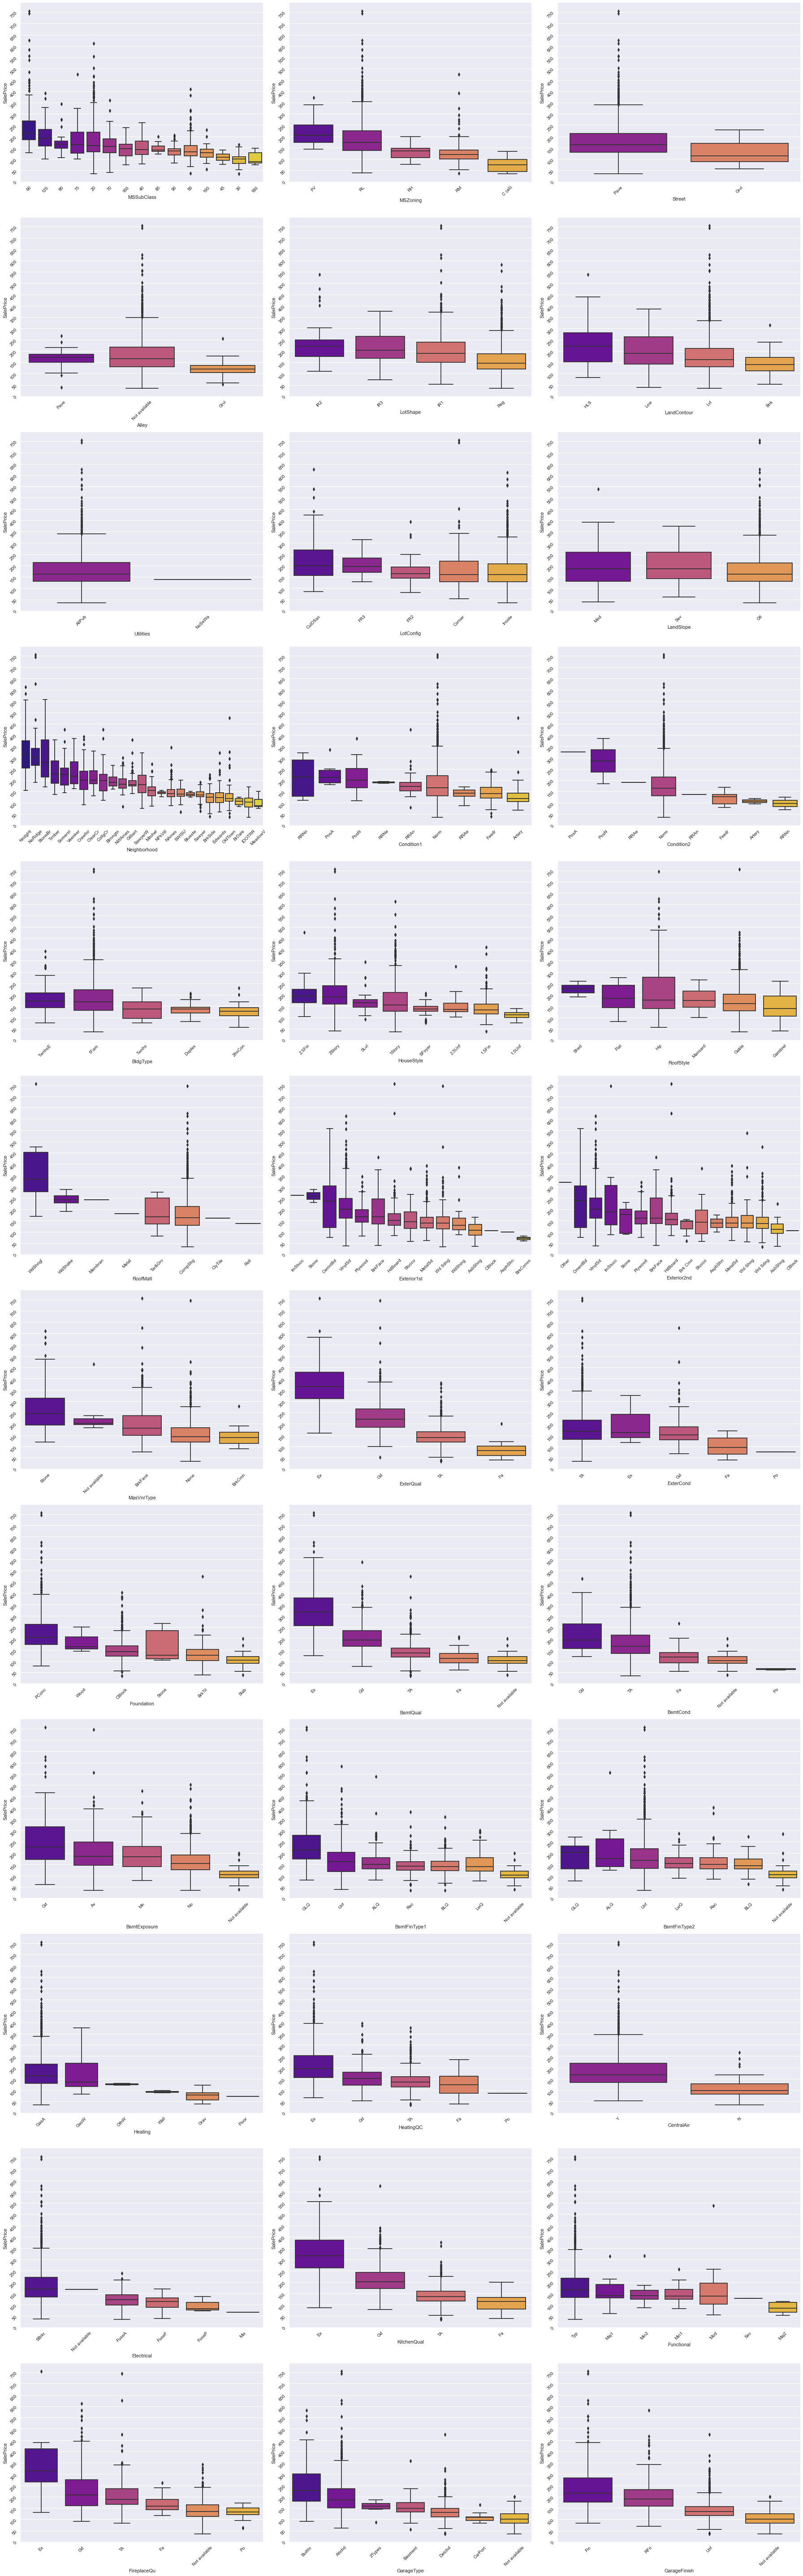

In [33]:
def srt_box(y, df):
    fig, axes = plt.subplots(12, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(train[[col for col in train.select_dtypes(include=['object'])]], axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(ticker.MaxNLocator(nbins=18))

        plt.tight_layout()
     

srt_box('SalePrice', train)

От диаграмите може да се направи извод, че има голямо нетипични стойности при категорийните променливи. Прави впечатление, че те често принадлежат към един или два класа от съответната категория, най-често в посока нагоре, което може да означава, че категорията не едобре разделена на класове или че променливата е излишна като цяло, тъй като в една категория попадат почти всички записи и има нужда от задълбочен анализ, който да създаде подредени или неподредени стойности, които правилно да описват обектите на оценка.

#### Фючър селекшън на категорийни променливи

Всички променливи, които касаят оценка на състояние и качество, са силно натоварени със субективното мнение на даващия оценката. Това може да бъде както едно лице, така и различни лица. Променливите трябва да бъдат измерими и обективни. Преценям, че тези променливи и зададените в тях стойности в голяма степен може да обърква моделите и ги отстранявам. 

In [34]:
train = train.drop(['ExterQual', 'ExterCond', 'BsmtCond', 'HeatingQC', 
                    'KitchenQual', 'FireplaceQu', 'GarageQual','GarageCond',
                   'BsmtFinType1', 'BsmtFinType2'], axis=1)

В част от променливите, почти всички стойноти са съсредоточени само в един от класовете й. Това води до извод, че същата няма особена тежест в цената на имота и затова тези променливи се премахват.

In [35]:
categorical_description_df[categorical_description_df.freq > 1400]

,count,unique,top,freq
Street,1460,2,Pave,1454
Utilities,1460,2,AllPub,1459
Condition2,1460,8,Norm,1445
RoofMatl,1460,8,CompShg,1434
Heating,1460,6,GasA,1428
MiscFeature,1460,5,Not available,1406


In [36]:
train = train.drop(categorical_description_df[categorical_description_df.freq > 1400].index, axis=1)

#### Отстраняване на малък брой забележими аутлайъри в променливите с най-висока корелация със зависимата променлива.

In [37]:
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300) ].index)
train = train.drop(train[(train.GrLivArea > 500) & (train.SalePrice < 50)].index)
train = train.drop(train[(train.OverallCond < 3) & (train.SalePrice > 300)].index)

### 3. Анализ на зависимата променлива 

In [38]:
train.SalePrice.describe()

count    1454.000000
mean      181.081818
std        79.139377
min        35.311000
25%       130.000000
50%       163.000000
75%       214.000000
max       755.000000
Name: SalePrice, dtype: float64

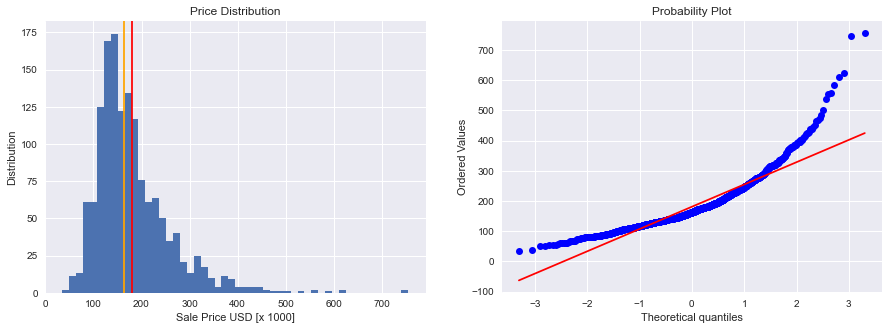

In [39]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(train.SalePrice, bins=50)
plt.axvline(train.SalePrice.mean(), color='red')
plt.axvline(train.SalePrice.median(), color='orange')
plt.title('Price Distribution')
plt.xlabel('Sale Price USD [х 1000]')
plt.ylabel('Distribution')

plt.subplot(1,2,2)
stats.probplot(train['SalePrice'], plot=plt)

plt.show()

От описанието и хистограмата на променливата "Цена", се вижда, че 75% от стойностите на имотите са под 214хил, което ще създаде проблем при предвижданията.
Ще приложим log transformation, така че грешките при прогнозиране на скъпи къщи и евтини къщи да повлияят еднакво на резултата. 

In [40]:
log_prices = np.log1p(train.SalePrice)

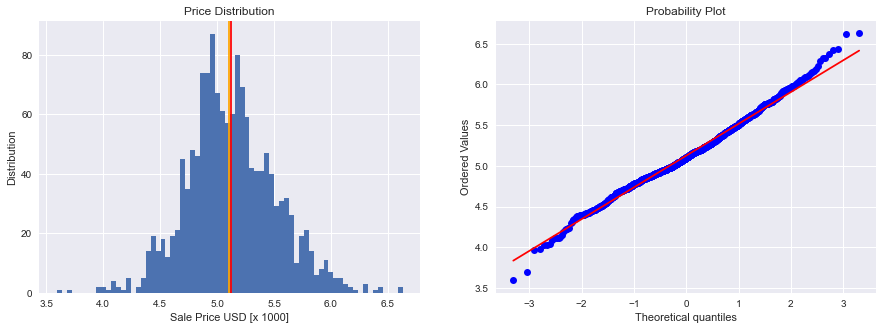

In [41]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(log_prices, bins=70)
plt.axvline(log_prices.mean(), color='red')
plt.axvline(log_prices.median(), color='orange')
plt.title('Price Distribution')
plt.xlabel('Sale Price USD [х 1000]')
plt.ylabel('Distribution')

plt.subplot(1,2,2)
stats.probplot(log_prices, plot=plt)

plt.show()

От диаграмите в анализа на цифровите променливи се забелязва, че голяма част от тях са със сходно разпределение. Забелязва се характерната фуниевидна форма - хетероскедастик шейп. Наличието на хетероскедастичност е основен проблем при регресионния анализ. Познати са редица методи за корекция на това явление, но за целите на настоящия проект, ще подходим по същия начин като при зависимата променлива и ще приложим логаритмична трансформация както на зависимата променлива, така и на всички променливи, които са със скю > 0,5. Този филтър се налага, тъй като прилагането на трансформацията върху данни с по-малко изкривяване, може да доведе до обратния ефект.

In [42]:
skewness = train.select_dtypes(exclude='object').skew()
skewed_features = skewness[abs(skewness) > 0.5]
# symmetrical_features = skewness[abs(skewness) < 0.5]

train_log = train.copy()
for df in [train_log]:
    for col in skewed_features.index:
        df[col] = np.log1p(df[col])

### 3. Подготовка и разделяне на данните на сетове за трениране и тестване

In [43]:
train_log.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,Fence,SaleType,SaleCondition,SalePrice
0,60,RL,4.189655,9.042040,Not available,Reg,Lvl,Inside,Gtl,CollgCr,...,Y,0.000000,4.127134,0.000000,0.0,0.0,Not available,WD,Normal,5.344724
1,20,RL,4.394449,9.169623,Not available,Reg,Lvl,FR2,Gtl,Veenker,...,Y,5.700444,0.000000,0.000000,0.0,0.0,Not available,WD,Normal,5.206750
2,60,RL,4.234107,9.328212,Not available,IR1,Lvl,Inside,Gtl,CollgCr,...,Y,0.000000,3.761200,0.000000,0.0,0.0,Not available,WD,Normal,5.413876
3,70,RL,4.110874,9.164401,Not available,IR1,Lvl,Corner,Gtl,Crawfor,...,Y,0.000000,3.583519,5.609472,0.0,0.0,Not available,WD,Abnorml,4.948760
4,60,RL,4.442651,9.565284,Not available,IR1,Lvl,FR2,Gtl,NoRidge,...,Y,5.262690,4.442651,0.000000,0.0,0.0,Not available,WD,Normal,5.525453


In [44]:
train_log.shape

(1454, 49)

Разделям данните на фючърси и таргет

In [45]:
train_features = train_log.drop('SalePrice', axis=1)
train_target = train_log['SalePrice']

In [46]:
train_features.shape, train_target.shape

((1454, 48), (1454,))

Задавам бинарни стойности на категорийните променливи. Преценям, че скалиране на данните не е необходимо.

In [47]:
train_features= pd.get_dummies(train_features)

In [48]:
 train_features

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7,1.791759,7.602900,7.602900,5.283204,6.753438,7.444833,0.693147,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,6,2.197225,7.589336,7.589336,0.000000,7.141245,7.141245,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,7,1.791759,7.601902,7.602401,5.093750,6.825460,7.488294,0.693147,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,7,1.791759,7.557995,7.586296,0.000000,6.629363,7.448916,0.693147,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,8,1.791759,7.601402,7.601402,5.860786,7.044033,7.695758,0.693147,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.143135,8.976894,6,1.791759,7.600902,7.601402,0.000000,6.860664,7.407318,0.000000,...,0,0,0,1,0,0,0,0,1,0
1456,4.454347,9.486152,6,1.945910,7.590347,7.595387,4.787492,7.341484,7.637234,0.693147,...,0,0,0,1,0,0,0,0,1,0
1457,4.204693,9.109746,7,2.302585,7.571474,7.604396,0.000000,7.050123,7.758333,0.000000,...,0,0,0,1,0,0,0,0,1,0
1458,4.234107,9.181735,5,1.945910,7.576097,7.599401,0.000000,6.983790,6.983790,0.693147,...,0,0,0,1,0,0,0,0,1,0


In [49]:
train_features_set, test_features_set, train_target_set, test_target_set = train_test_split(
    train_features, train_target, test_size = 300, stratify=train.HouseStyle, random_state=30)

In [50]:
train_features_set.shape, train_target_set.shape, 

((1154, 214), (1154,))

In [51]:
test_features_set.shape, test_target_set.shape

((300, 214), (300,))

In [52]:
k_fold = KFold(n_splits=5)
k_fold_train_splits = list(k_fold.split(train_features_set, train_target_set))

### 4. Създаване на модели и тяхното оценяване


* Linear Regression - Линейната регресия е един от най-популярни алгоритми в машинното обучение, тъй като е лесна и ясна за разбиране. В този проект ще я използваме за прогнозиране на цените на жилища, за да намерим възможно най-добрата линия, която следва тренировъчния ни сет, след което ще прогнозираме цена на имота от тестовия набор.
* Регресията на Lasso Lars е една от техникитe за намаляване на сложността на модела и предотвратяване прекалено следване на данните. Параметрите на регуляризация могат да бъдат контролирани и по този начин да се постигне по-точна оценка на цените на жилищата.
* Ridge
* RANSAC - 
* DecisionTree - Дърво на решенията
* GBR - Регресията за повишаване на градиента (GBR) е машинно обучение, което може да се използва за изграждане на прогнозен модел за регресионни проблеми като прогнозира цените на жилищата под формата на ансамбъл от слаби прогнози модели. GBR повтаря многократно моделите и засилва прогнозата на моделите със слаби прогнози и ги прави по -добъри. Основната цел е да намалим до минимум нашата Loss функция. 
* LinearSVR
* SVR 

### Linear Regression Grid Search 

In [53]:
params = {
#     'normalize':[True, False],
    'fit_intercept': [True, False]
}
grid_search_lin_reg = GridSearchCV(estimator=LinearRegression(), param_grid=params, cv=k_fold_train_splits)
grid_search_lin_reg.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_lin_reg.cv_results_).T

,0,1
mean_fit_time,0.0156443,0.0169304
std_fit_time,2.95612e-05,0.00255533
mean_score_time,0,0
std_score_time,0,0
param_fit_intercept,True,False
params,{'fit_intercept': True},{'fit_intercept': False}
split0_test_score,-6.0225e+19,0.446112
split1_test_score,-2.98877e+21,0.816655
split2_test_score,-8.84898e+16,0.895899
split3_test_score,-7.34823e+20,0.678509


In [54]:
evaluate(grid_search_lin_reg.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.944151102200899
Mean Absolute Error: 0.06617685895991726

**************************************************
TEST Sets results:

R2 Score: 0.8386260705192788
Mean Absolute Error: 0.09213540146846547


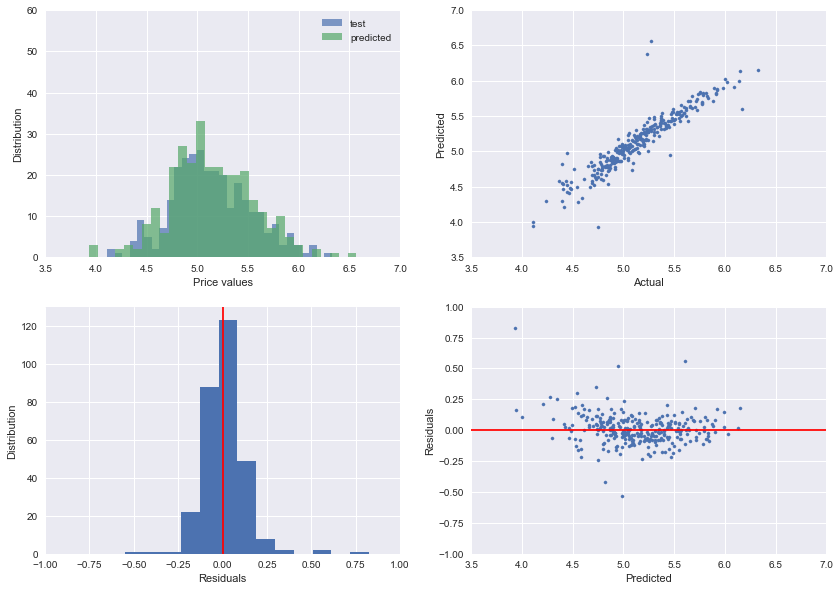

In [55]:
y_predict = grid_search_lin_reg.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predict)

### Lasso Grid Search 

In [56]:
params = {
    'alpha': [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007],
#     'fit_intercept': [True, False],
    'max_iter': [1000, 10000, 20000],
}
grid_search_lasso = GridSearchCV(estimator=Lasso(), param_grid=params, cv=k_fold_train_splits)
grid_search_lasso.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_lasso.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean_fit_time,0.0139036,0.0163106,0.0163897,0.0143571,0.0120195,0.0133858,0.0174089,0.0145725,0.0121676,0.0136724,0.0137405,0.0140775,0.0116853,0.0117733,0.00888348,0.0100748,0.0100749,0.0116649
std_fit_time,0.00377539,0.00430848,0.00490479,0.00433459,0.0031692,0.00392862,0.00377533,0.00472054,0.00310041,0.00449909,0.00373665,0.00491105,0.00322876,0.00323939,0.00352264,2.17358e-05,2.49559e-05,0.00323378
mean_score_time,0.00242476,0.000418329,0.00353284,0.00403681,0.0036489,0.00243974,0.00080986,0.00324216,0.00404181,0.00080657,0.00241661,0,0.000407314,0.00364184,0.00523057,0.000410795,0.00201058,0.000404119
std_score_time,0.00294434,0.000836658,0.00435684,0.00423519,0.0036898,0.00295415,0.000991903,0.00397084,0.00420973,0.00098785,0.00295296,0,0.000814629,0.00368466,0.00432281,0.00082159,0.00311072,0.000808239
param_alpha,0.0002,0.0002,0.0002,0.0003,0.0003,0.0003,0.0004,0.0004,0.0004,0.0005,0.0005,0.0005,0.0006,0.0006,0.0006,0.0007,0.0007,0.0007
param_max_iter,1000,10000,20000,1000,10000,20000,1000,10000,20000,1000,10000,20000,1000,10000,20000,1000,10000,20000
params,"{'alpha': 0.0002, 'max_iter': 1000}","{'alpha': 0.0002, 'max_iter': 10000}","{'alpha': 0.0002, 'max_iter': 20000}","{'alpha': 0.0003, 'max_iter': 1000}","{'alpha': 0.0003, 'max_iter': 10000}","{'alpha': 0.0003, 'max_iter': 20000}","{'alpha': 0.0004, 'max_iter': 1000}","{'alpha': 0.0004, 'max_iter': 10000}","{'alpha': 0.0004, 'max_iter': 20000}","{'alpha': 0.0005, 'max_iter': 1000}","{'alpha': 0.0005, 'max_iter': 10000}","{'alpha': 0.0005, 'max_iter': 20000}","{'alpha': 0.0006, 'max_iter': 1000}","{'alpha': 0.0006, 'max_iter': 10000}","{'alpha': 0.0006, 'max_iter': 20000}","{'alpha': 0.0007, 'max_iter': 1000}","{'alpha': 0.0007, 'max_iter': 10000}","{'alpha': 0.0007, 'max_iter': 20000}"
split0_test_score,0.912624,0.912624,0.912624,0.911515,0.911515,0.911515,0.908685,0.908685,0.908685,0.906879,0.906879,0.906879,0.906398,0.906398,0.906398,0.905689,0.905689,0.905689
split1_test_score,0.897535,0.897535,0.897535,0.897418,0.897418,0.897418,0.895834,0.895834,0.895834,0.894234,0.894234,0.894234,0.893654,0.893654,0.893654,0.892992,0.892992,0.892992
split2_test_score,0.937283,0.937283,0.937283,0.937659,0.937659,0.937659,0.936782,0.936782,0.936782,0.935512,0.935512,0.935512,0.9341,0.9341,0.9341,0.932517,0.932517,0.932517


In [57]:
evaluate(grid_search_lasso.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9340267747070519
Mean Absolute Error: 0.07225633732677003

**************************************************
TEST Sets results:

R2 Score: 0.9335634024310305
Mean Absolute Error: 0.07793047156596285


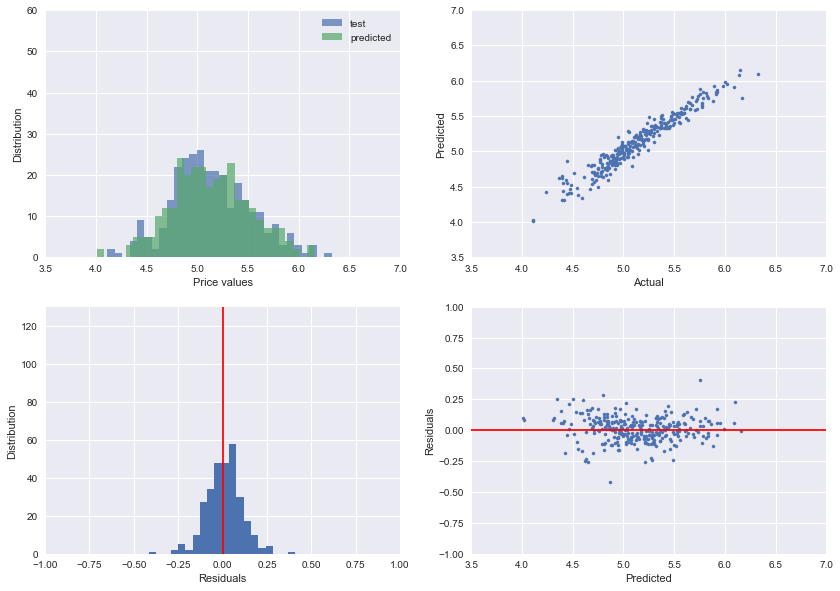

In [58]:
y_predicted_lasso = grid_search_lasso.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_lasso)

In [59]:
coef_df = pd.DataFrame(zip(test_features_set.columns.T, grid_search_lasso.best_estimator_.coef_ ), columns=['feature', 'coefficient'])
coef_df[abs(coef_df.coefficient) > 0].sort_values('coefficient', ascending=False).head(10)

,feature,coefficient
8,GrLivArea,0.412471
3,OverallCond,0.280797
158,BsmtQual_Not available,0.253249
75,Neighborhood_NoRidge,0.108136
9,BsmtFullBath,0.091811
82,Neighborhood_StoneBr,0.088696
76,Neighborhood_NridgHt,0.085556
66,Neighborhood_Crawfor,0.085436
1,LotArea,0.078961
116,Exterior1st_BrkFace,0.074455


### Ridge Grid Search

In [60]:
params = {
    'alpha': [2, 3, 4, 5, 6],
    'max_iter': [5000, 10000, 20000]
}
grid_search_ridge = GridSearchCV(estimator=Ridge(), param_grid=params, cv=k_fold_train_splits)
grid_search_ridge.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_ridge.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
mean_fit_time,0.00630374,0.00895586,0.00312533,0.00624857,0.00564947,0.00779338,0.00636215,0.00603828,0.00766625,0.00646787,0.00609198,0.00448961,0.00644984,0.00649476,0.00367937
std_fit_time,0.00772091,0.00735262,0.00625067,0.0076529,0.00528831,0.00393071,0.00458852,0.00421949,0.00391521,0.00449738,0.00423907,0.00389647,0.00366019,0.00324767,0.00373113
mean_score_time,0.00315857,0,0.00625081,0,0.00526705,0.00232058,0.00172324,0.00200968,0.00243402,0.00160799,0.00205121,0.00367012,0.00201378,0.00372581,0.0044508
std_score_time,0.00631714,0,0.00765565,0,0.00311926,0.0039181,0.00344648,0.00310962,0.00393503,0.00321598,0.00315345,0.00371777,0.00311047,0.00323533,0.00389042
param_alpha,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6
param_max_iter,5000,10000,20000,5000,10000,20000,5000,10000,20000,5000,10000,20000,5000,10000,20000
params,"{'alpha': 2, 'max_iter': 5000}","{'alpha': 2, 'max_iter': 10000}","{'alpha': 2, 'max_iter': 20000}","{'alpha': 3, 'max_iter': 5000}","{'alpha': 3, 'max_iter': 10000}","{'alpha': 3, 'max_iter': 20000}","{'alpha': 4, 'max_iter': 5000}","{'alpha': 4, 'max_iter': 10000}","{'alpha': 4, 'max_iter': 20000}","{'alpha': 5, 'max_iter': 5000}","{'alpha': 5, 'max_iter': 10000}","{'alpha': 5, 'max_iter': 20000}","{'alpha': 6, 'max_iter': 5000}","{'alpha': 6, 'max_iter': 10000}","{'alpha': 6, 'max_iter': 20000}"
split0_test_score,0.907045,0.907045,0.907045,0.907521,0.907521,0.907521,0.907353,0.907353,0.907353,0.906856,0.906856,0.906856,0.906178,0.906178,0.906178
split1_test_score,0.896849,0.896849,0.896849,0.897578,0.897578,0.897578,0.897767,0.897767,0.897767,0.897645,0.897645,0.897645,0.897331,0.897331,0.897331
split2_test_score,0.934738,0.934738,0.934738,0.935076,0.935076,0.935076,0.934941,0.934941,0.934941,0.934606,0.934606,0.934606,0.934174,0.934174,0.934174


In [61]:
evaluate(grid_search_ridge.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9349680143063358
Mean Absolute Error: 0.07176270772593235

**************************************************
TEST Sets results:

R2 Score: 0.9281552327108932
Mean Absolute Error: 0.07935717029910272


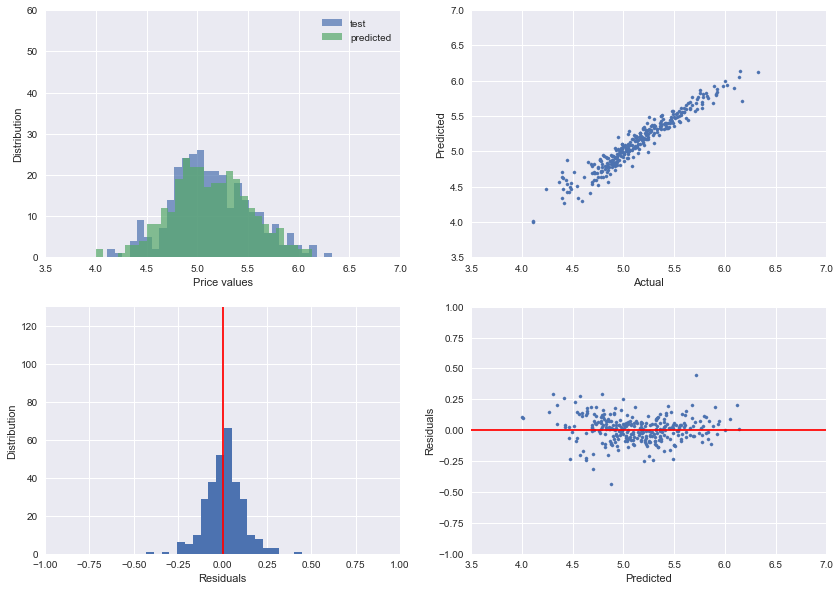

In [62]:
y_predicted_ridge = grid_search_ridge.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_ridge)

### RANSAC Grid Search

In [63]:
params = {
#     'min_samples': [300, 350, 400, 420, 450, 500]
    'min_samples': [0.94, 0.95, 0.96, 0.97, 0.99],
#     'stop_score':[0.97]
}
grid_search_ransac = GridSearchCV(estimator=RANSACRegressor(base_estimator=grid_search_lasso.best_estimator_, random_state=1), 
                                  param_grid=params, 
                                  cv=k_fold_train_splits)
grid_search_ransac.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_ransac.cv_results_).T

,0,1,2,3,4
mean_fit_time,1.19495,1.27488,1.28325,1.19737,1.29127
std_fit_time,0.0892511,0.123585,0.0885838,0.0797224,0.100651
mean_score_time,0.00425606,0.000806189,0.00433407,0.00480628,0.00364203
std_score_time,0.00372701,0.000987377,0.00396607,0.00367203,0.00370131
param_min_samples,0.94,0.95,0.96,0.97,0.99
params,{'min_samples': 0.94},{'min_samples': 0.95},{'min_samples': 0.96},{'min_samples': 0.97},{'min_samples': 0.99}
split0_test_score,0.918928,0.918928,0.919067,0.918486,0.917133
split1_test_score,0.89321,0.893245,0.892235,0.893344,0.892042
split2_test_score,0.931297,0.931297,0.931139,0.931139,0.931139
split3_test_score,0.899026,0.89922,0.900559,0.898932,0.898932


In [64]:
evaluate(grid_search_ransac.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9277472360345591
Mean Absolute Error: 0.0718545217180868

**************************************************
TEST Sets results:

R2 Score: 0.9303024446804149
Mean Absolute Error: 0.07866773521792067


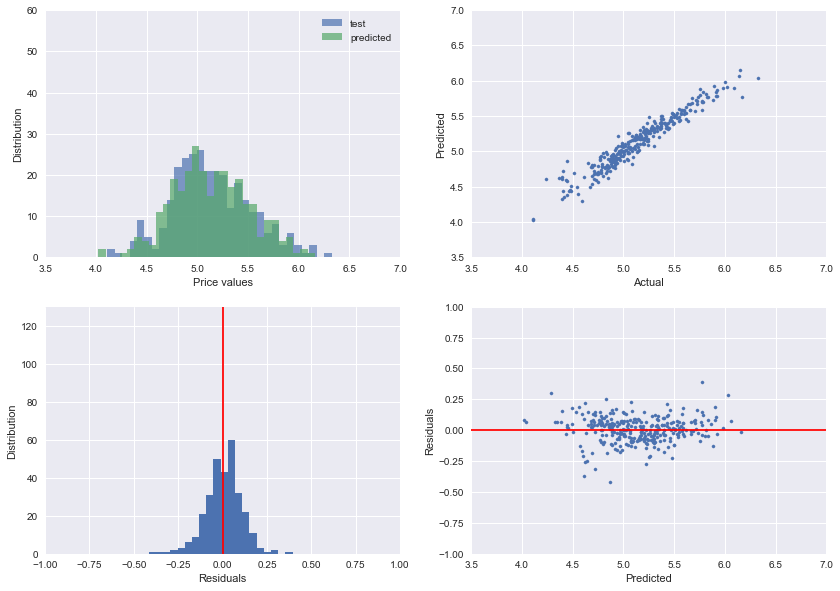

In [65]:
y_predicted_ransac = grid_search_ransac.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_ransac)

In [66]:
inliers = train_features_set[grid_search_ransac.best_estimator_.inlier_mask_]
outliers = train_features_set[~grid_search_ransac.best_estimator_.inlier_mask_]
len(inliers), len(outliers)

(1125, 29)

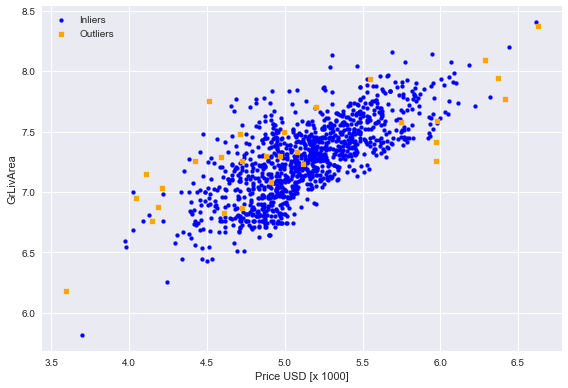

In [67]:
plt.scatter(
    train_target_set[inliers.index], 
    train_features_set.GrLivArea[inliers.index], 
    c='blue', 
    marker='o', 
    s= 15, 
    label='Inliers'
)
plt.scatter(
    train_target_set[outliers.index], 
    train_features_set.GrLivArea[outliers.index], 
    c='orange', 
    marker='s', 
    s=25, 
    label='Outliers'
)

plt.xlabel('Price USD [x 1000]')
plt.ylabel('GrLivArea')
plt.legend(loc='upper left')
 
plt.tight_layout()
plt.show()

In [68]:
grid_search_ransac.best_estimator_ = grid_search_ransac.best_estimator_.fit(inliers, train_target_set[inliers.index])

In [69]:
evaluate(grid_search_ransac.best_estimator_, inliers, train_target_set[inliers.index], test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9517228470172692
Mean Absolute Error: 0.06355069104852179

**************************************************
TEST Sets results:

R2 Score: 0.9318419588119254
Mean Absolute Error: 0.07777790505875913


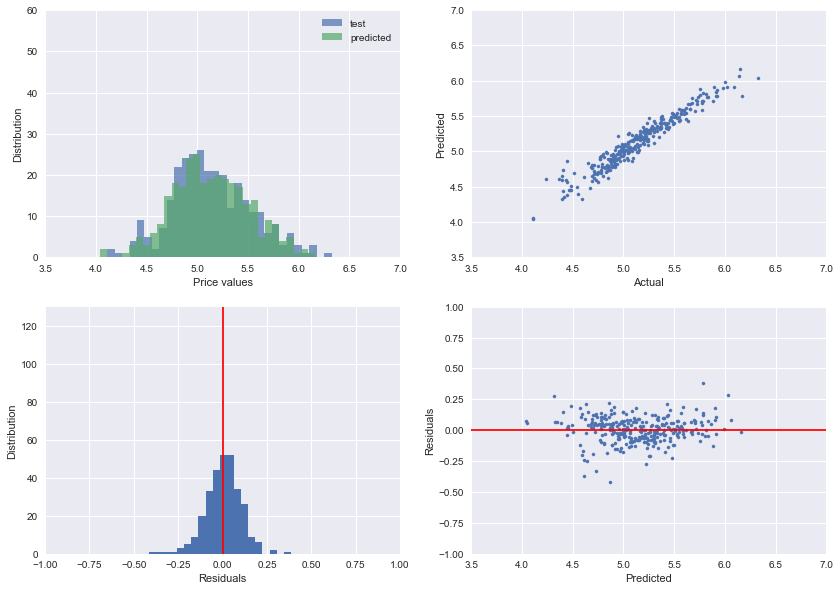

In [70]:
y_predicted_ransac = grid_search_ransac.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_ransac)

### Decision Tree Grid Search

In [71]:
params = {
    'max_depth': [7,8, 9, 10, 11,12],
    'max_leaf_nodes': [30,40, 50, 60, 70, 80,90],
    'min_samples_leaf': [2,3, 4, 5, 7, 10],
    'max_features': [70,80,100, 110, 120]   
}
grid_search_DTR = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=params, cv=k_fold_train_splits)
grid_search_DTR.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_DTR.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259
mean_fit_time,0.00626621,0.00624394,0.00939212,0.00625062,0.00766258,0.00740466,0.00903707,0.00694604,0.00700207,0.00944309,...,0.00828843,0.00878439,0.00988641,0.00710921,0.0102448,0.0103679,0.0103058,0.00819521,0.00820169,0.0102507
std_fit_time,0.00767461,0.00764725,0.00766876,0.00765542,0.00608683,0.0038314,0.00680214,0.00356799,0.00399334,0.00105761,...,0.00313609,0.0032461,0.000883346,0.00399951,1.91573e-05,0.000236996,0.000102445,0.00315698,0.00315195,2.63909e-05
mean_score_time,0.00312953,0,0.00132098,0.00312338,0,0.00248337,0.0016243,0.002916,0.0016273,0.000843668,...,0.00413771,0.00162325,0.000884008,0.0048821,0.0020503,0.00194559,0.00204325,0.00205221,0.00246754,0.00163183
std_score_time,0.00625906,0,0.00264196,0.00624676,0,0.00298868,0.0032486,0.00276051,0.0032546,0.00103328,...,0.00426679,0.0032465,0.00108392,0.00398625,0.00314161,0.0031439,0.00314107,0.00315757,0.00297465,0.00326366
param_max_depth,7,7,7,7,7,7,7,7,7,7,...,12,12,12,12,12,12,12,12,12,12
param_max_features,70,70,70,70,70,70,70,70,70,70,...,120,120,120,120,120,120,120,120,120,120
param_max_leaf_nodes,30,30,30,30,30,30,40,40,40,40,...,80,80,80,80,90,90,90,90,90,90
param_min_samples_leaf,2,3,4,5,7,10,2,3,4,5,...,4,5,7,10,2,3,4,5,7,10
params,"{'max_depth': 7, 'max_features': 70, 'max_leaf...","{'max_depth': 7, 'max_features': 70, 'max_leaf...","{'max_depth': 7, 'max_features': 70, 'max_leaf...","{'max_depth': 7, 'max_features': 70, 'max_leaf...","{'max_depth': 7, 'max_features': 70, 'max_leaf...","{'max_depth': 7, 'max_features': 70, 'max_leaf...","{'max_depth': 7, 'max_features': 70, 'max_leaf...","{'max_depth': 7, 'max_features': 70, 'max_leaf...","{'max_depth': 7, 'max_features': 70, 'max_leaf...","{'max_depth': 7, 'max_features': 70, 'max_leaf...",...,"{'max_depth': 12, 'max_features': 120, 'max_le...","{'max_depth': 12, 'max_features': 120, 'max_le...","{'max_depth': 12, 'max_features': 120, 'max_le...","{'max_depth': 12, 'max_features': 120, 'max_le...","{'max_depth': 12, 'max_features': 120, 'max_le...","{'max_depth': 12, 'max_features': 120, 'max_le...","{'max_depth': 12, 'max_features': 120, 'max_le...","{'max_depth': 12, 'max_features': 120, 'max_le...","{'max_depth': 12, 'max_features': 120, 'max_le...","{'max_depth': 12, 'max_features': 120, 'max_le..."
split0_test_score,0.692607,0.763081,0.70078,0.701743,0.741042,0.721664,0.671788,0.735477,0.748054,0.744777,...,0.749301,0.72575,0.755862,0.733661,0.718018,0.733114,0.764289,0.688379,0.753506,0.768812


In [72]:
grid_search_DTR.best_params_

{'max_depth': 9,
 'max_features': 110,
 'max_leaf_nodes': 80,
 'min_samples_leaf': 7}

In [73]:
evaluate(grid_search_DTR.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.8897877110233722
Mean Absolute Error: 0.09687528137218807

**************************************************
TEST Sets results:

R2 Score: 0.8589625258287032
Mean Absolute Error: 0.1131006242158181


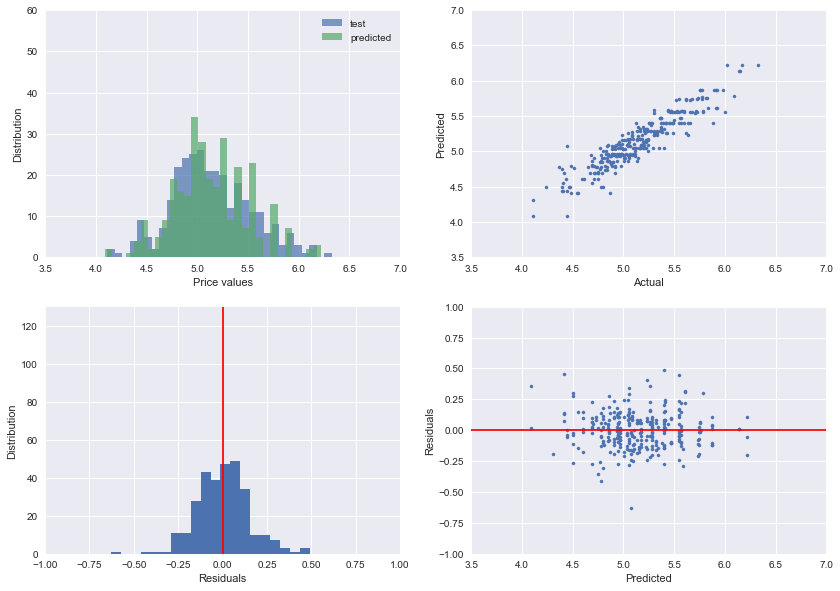

In [74]:
y_predicted_grid_dtr = grid_search_DTR.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_grid_dtr)

### Grid Search GBR - Gradient Boosting Regressor

In [75]:
params = {
#     'loss': ['ls', 'lad', 'huber'],
    'n_estimators': [200, 250, 300],
    'subsample': [0.6, 0.7, 0.8, 0.9]
}
grid_search_gbr = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=params, cv=k_fold_train_splits)
grid_search_gbr.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_gbr.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11
mean_fit_time,0.566574,0.545684,0.674333,0.754722,0.653326,0.688369,0.785534,0.86083,0.74633,0.871457,0.946454,1.05308
std_fit_time,0.0236171,0.000847091,0.0322041,0.0344433,0.0336469,0.0125599,0.00537735,0.00649142,0.0223836,0.0456097,0.0221766,0.00574106
mean_score_time,0.000827408,0.00162263,0.00530014,0.000846958,0.00088439,0.00163012,0,0.00368319,0.0036613,0.000829124,0.00327992,0.00250149
std_score_time,0.00165482,0.00324526,0.00439696,0.00103731,0.00108451,0.00326023,0,0.00373155,0.00370988,0.00101571,0.00401742,0.00403323
param_n_estimators,200,200,200,200,250,250,250,250,300,300,300,300
param_subsample,0.6,0.7,0.8,0.9,0.6,0.7,0.8,0.9,0.6,0.7,0.8,0.9
params,"{'n_estimators': 200, 'subsample': 0.6}","{'n_estimators': 200, 'subsample': 0.7}","{'n_estimators': 200, 'subsample': 0.8}","{'n_estimators': 200, 'subsample': 0.9}","{'n_estimators': 250, 'subsample': 0.6}","{'n_estimators': 250, 'subsample': 0.7}","{'n_estimators': 250, 'subsample': 0.8}","{'n_estimators': 250, 'subsample': 0.9}","{'n_estimators': 300, 'subsample': 0.6}","{'n_estimators': 300, 'subsample': 0.7}","{'n_estimators': 300, 'subsample': 0.8}","{'n_estimators': 300, 'subsample': 0.9}"
split0_test_score,0.904691,0.894945,0.89116,0.887403,0.898213,0.900253,0.893993,0.890391,0.899516,0.894421,0.88754,0.887948
split1_test_score,0.890152,0.89167,0.902142,0.886964,0.891019,0.888786,0.892809,0.893575,0.889357,0.892937,0.901458,0.894162
split2_test_score,0.927097,0.924998,0.922592,0.923318,0.922793,0.930753,0.920628,0.922591,0.921567,0.921905,0.925477,0.925316


In [76]:
grid_search_gbr.best_params_

{'n_estimators': 250, 'subsample': 0.7}

In [77]:
evaluate(grid_search_gbr.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.978789665656306
Mean Absolute Error: 0.04376127878332798

**************************************************
TEST Sets results:

R2 Score: 0.9374684549897143
Mean Absolute Error: 0.07219907131414761


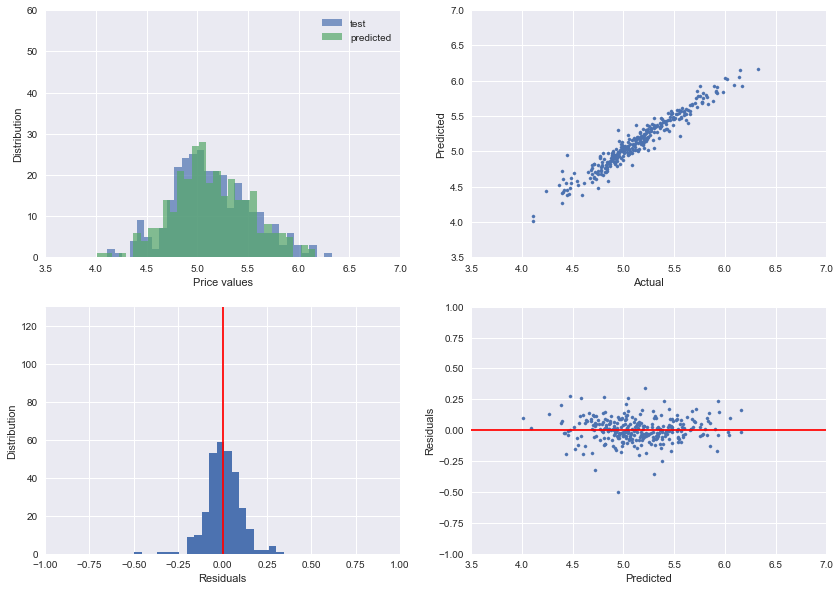

In [78]:
y_predicted_gbr = grid_search_gbr.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_gbr)

In [79]:
feature_importance_grid_gbr = pd.DataFrame(zip(train_features_set.columns, grid_search_gbr.best_estimator_.feature_importances_), columns=['feature', 'value'])

In [80]:
feature_importance_grid_gbr.sort_values(by='value', ascending=False).head(10)

,feature,value
2,OverallQual,0.408216
8,GrLivArea,0.178321
7,TotalBsmtSF,0.077070
4,YearBuilt,0.058640
15,GarageCars,0.058413
3,OverallCond,0.029596
5,YearRemodAdd,0.028188
1,LotArea,0.018439
14,Fireplaces,0.014386
166,CentralAir_Y,0.009700


### Grid Search Linear SVR

In [81]:
# params = {
# #     'kernel': ['linear', 'poly', 'rbf'],
#     'C': [0.007, 0.008, 0.009, 0.01, 0.02, 0.03],
# #     'max_iter': [100000, 200000]
# }
# grid_search_svr = GridSearchCV(estimator=SVR(), param_grid=params, cv=k_fold_train_splits)
# grid_search_svr.fit(train_features_set, train_target_set)
# pd.DataFrame(grid_search_svr.cv_results_).T

In [82]:
# grid_search_svr.best_estimator_.get_params()

In [83]:
# evaluate(grid_search_svr.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

In [84]:
# y_predicted_svr = grid_search_svr.best_estimator_.predict(test_features_set)

In [85]:
# plot(test_target_set, y_predicted_svr)

### 5. Резултати

In [86]:
all_models_dict = {
    'Linear Regression': grid_search_lin_reg.best_estimator_, 
    'Lasso': grid_search_lasso.best_estimator_,
    'Ridge': grid_search_ridge.best_estimator_,
    'RANSAC Regressor': grid_search_ransac.best_estimator_,
    'Decision Tree Regressor': grid_search_DTR.best_estimator_, 
    'Gradient Boosting Regressor': grid_search_gbr.best_estimator_,
#     'SVR': grid_search_svr.best_estimator_
             }

In [87]:
results_df = pd.DataFrame(columns=['Model','R2 - train', 'R2 - test','MAE - test', 'MAPE - test'])
for name, model in all_models_dict.items():
    result = pd.DataFrame(
        data=[[name, *final_evaluation(model, train_features_set, train_target_set, test_features_set, test_target_set)]], 
        columns=['Model', 'R2 - train', 'R2 - test','MAE - test', 'MAPE - test']
    )
    results_df = results_df.append(result, ignore_index=True) 
    
results_df

,Model,R2 - train,R2 - test,MAE - test,MAPE - test
0,Linear Regression,0.944151,0.838626,17.764656,0.099260
1,Lasso,0.934027,0.933563,13.859615,0.078231
2,Ridge,0.934968,0.928155,14.090687,0.079593
3,RANSAC Regressor,0.927358,0.931842,13.978274,0.078744
4,Decision Tree Regressor,0.889788,0.858963,20.770009,0.114223
5,Gradient Boosting Regressor,0.978790,0.937468,13.086047,0.072921


### Избор на най-добрия модел и анализ на резултатите от него

In [100]:
# Извеждаме моделът с най-добър резултат и неговите прогнози
best_model = results_df.Model[results_df['MAPE - test'] == results_df['MAPE - test'].min()].values
best_prediction = all_models_dict[best_model[0]].predict(test_features_set)
best_model

array(['Gradient Boosting Regressor'], dtype=object)

In [101]:
# Създаваме таблица с резултатите на най-добрия модел
test_prices = np.expm1(test_target_set)
predicted_prices = np.expm1(best_prediction)
residuals = test_prices - predicted_prices
predicted_prices_df = pd.DataFrame({'test_set_index': test_target_set.index,
                                    'test_price': list(test_prices), 
                                    'predicted_price': list(predicted_prices), 
                                    'residuals': list((residuals)), 
                                    'residuals_%': list(((residuals)/test_prices)*100),
                                    })
predicted_prices_df

,test_set_index,test_price,predicted_price,residuals,residuals_%
0,471,190.0,194.174161,-4.174161,-2.196927
1,578,146.0,160.812378,-14.812378,-10.145464
2,678,372.5,337.319832,35.180168,9.444341
3,962,155.0,159.293152,-4.293152,-2.769776
4,921,145.9,168.208784,-22.308784,-15.290462
...,...,...,...,...,...
295,1105,325.0,338.758442,-13.758442,-4.233367
296,730,236.5,260.784032,-24.284032,-10.268090
297,247,140.0,146.382304,-6.382304,-4.558788
298,779,135.0,140.581914,-5.581914,-4.134751


In [103]:
# Извеждаме предвижданията, чиито процент остатъци са по-малко или равни на 5%
len(predicted_prices_df[abs(predicted_prices_df['residuals_%']) <= 7])/len(predicted_prices_df)

0.6

In [104]:
test_prices.sum(), predicted_prices.sum()

(55346.742, 54779.826637530816)

### Изводи
На база на изведените резултати, може да се направят следните изводи:
* Най-добрият модел може да бъде използван за предвиждане на стойността на пакети от недвижими имоти

Предвид множеството субективни фактори, влияещи върху взимането на решение за покупка на недвижим имот, считаме, че моделите биха имали по-добър резултат при по-обстоен анализ за селектиране на променливите, техния инженеринг, както и при работа с по-голям обем от данни.

### 6. Ресурси